Added trial 0 mask 0 data to salp_navigate_8a_hpc/gcn
Added trial 0 mask 1 data to salp_navigate_8a_hpc/gcn
Added trial 0 mask 2 data to salp_navigate_8a_hpc/gcn
Added trial 0 mask 3 data to salp_navigate_8a_hpc/gcn
Added trial 1 mask 0 data to salp_navigate_8a_hpc/gcn
Added trial 1 mask 1 data to salp_navigate_8a_hpc/gcn
Added trial 1 mask 2 data to salp_navigate_8a_hpc/gcn
Added trial 1 mask 3 data to salp_navigate_8a_hpc/gcn
Added trial 2 mask 0 data to salp_navigate_8a_hpc/gcn
Added trial 2 mask 1 data to salp_navigate_8a_hpc/gcn
Added trial 2 mask 2 data to salp_navigate_8a_hpc/gcn
Added trial 2 mask 3 data to salp_navigate_8a_hpc/gcn
Added trial 3 mask 0 data to salp_navigate_8a_hpc/gcn
Added trial 3 mask 1 data to salp_navigate_8a_hpc/gcn
Added trial 3 mask 2 data to salp_navigate_8a_hpc/gcn
Added trial 3 mask 3 data to salp_navigate_8a_hpc/gcn
Added trial 4 mask 0 data to salp_navigate_8a_hpc/gcn
Added trial 4 mask 1 data to salp_navigate_8a_hpc/gcn
Added trial 4 mask 2 data to

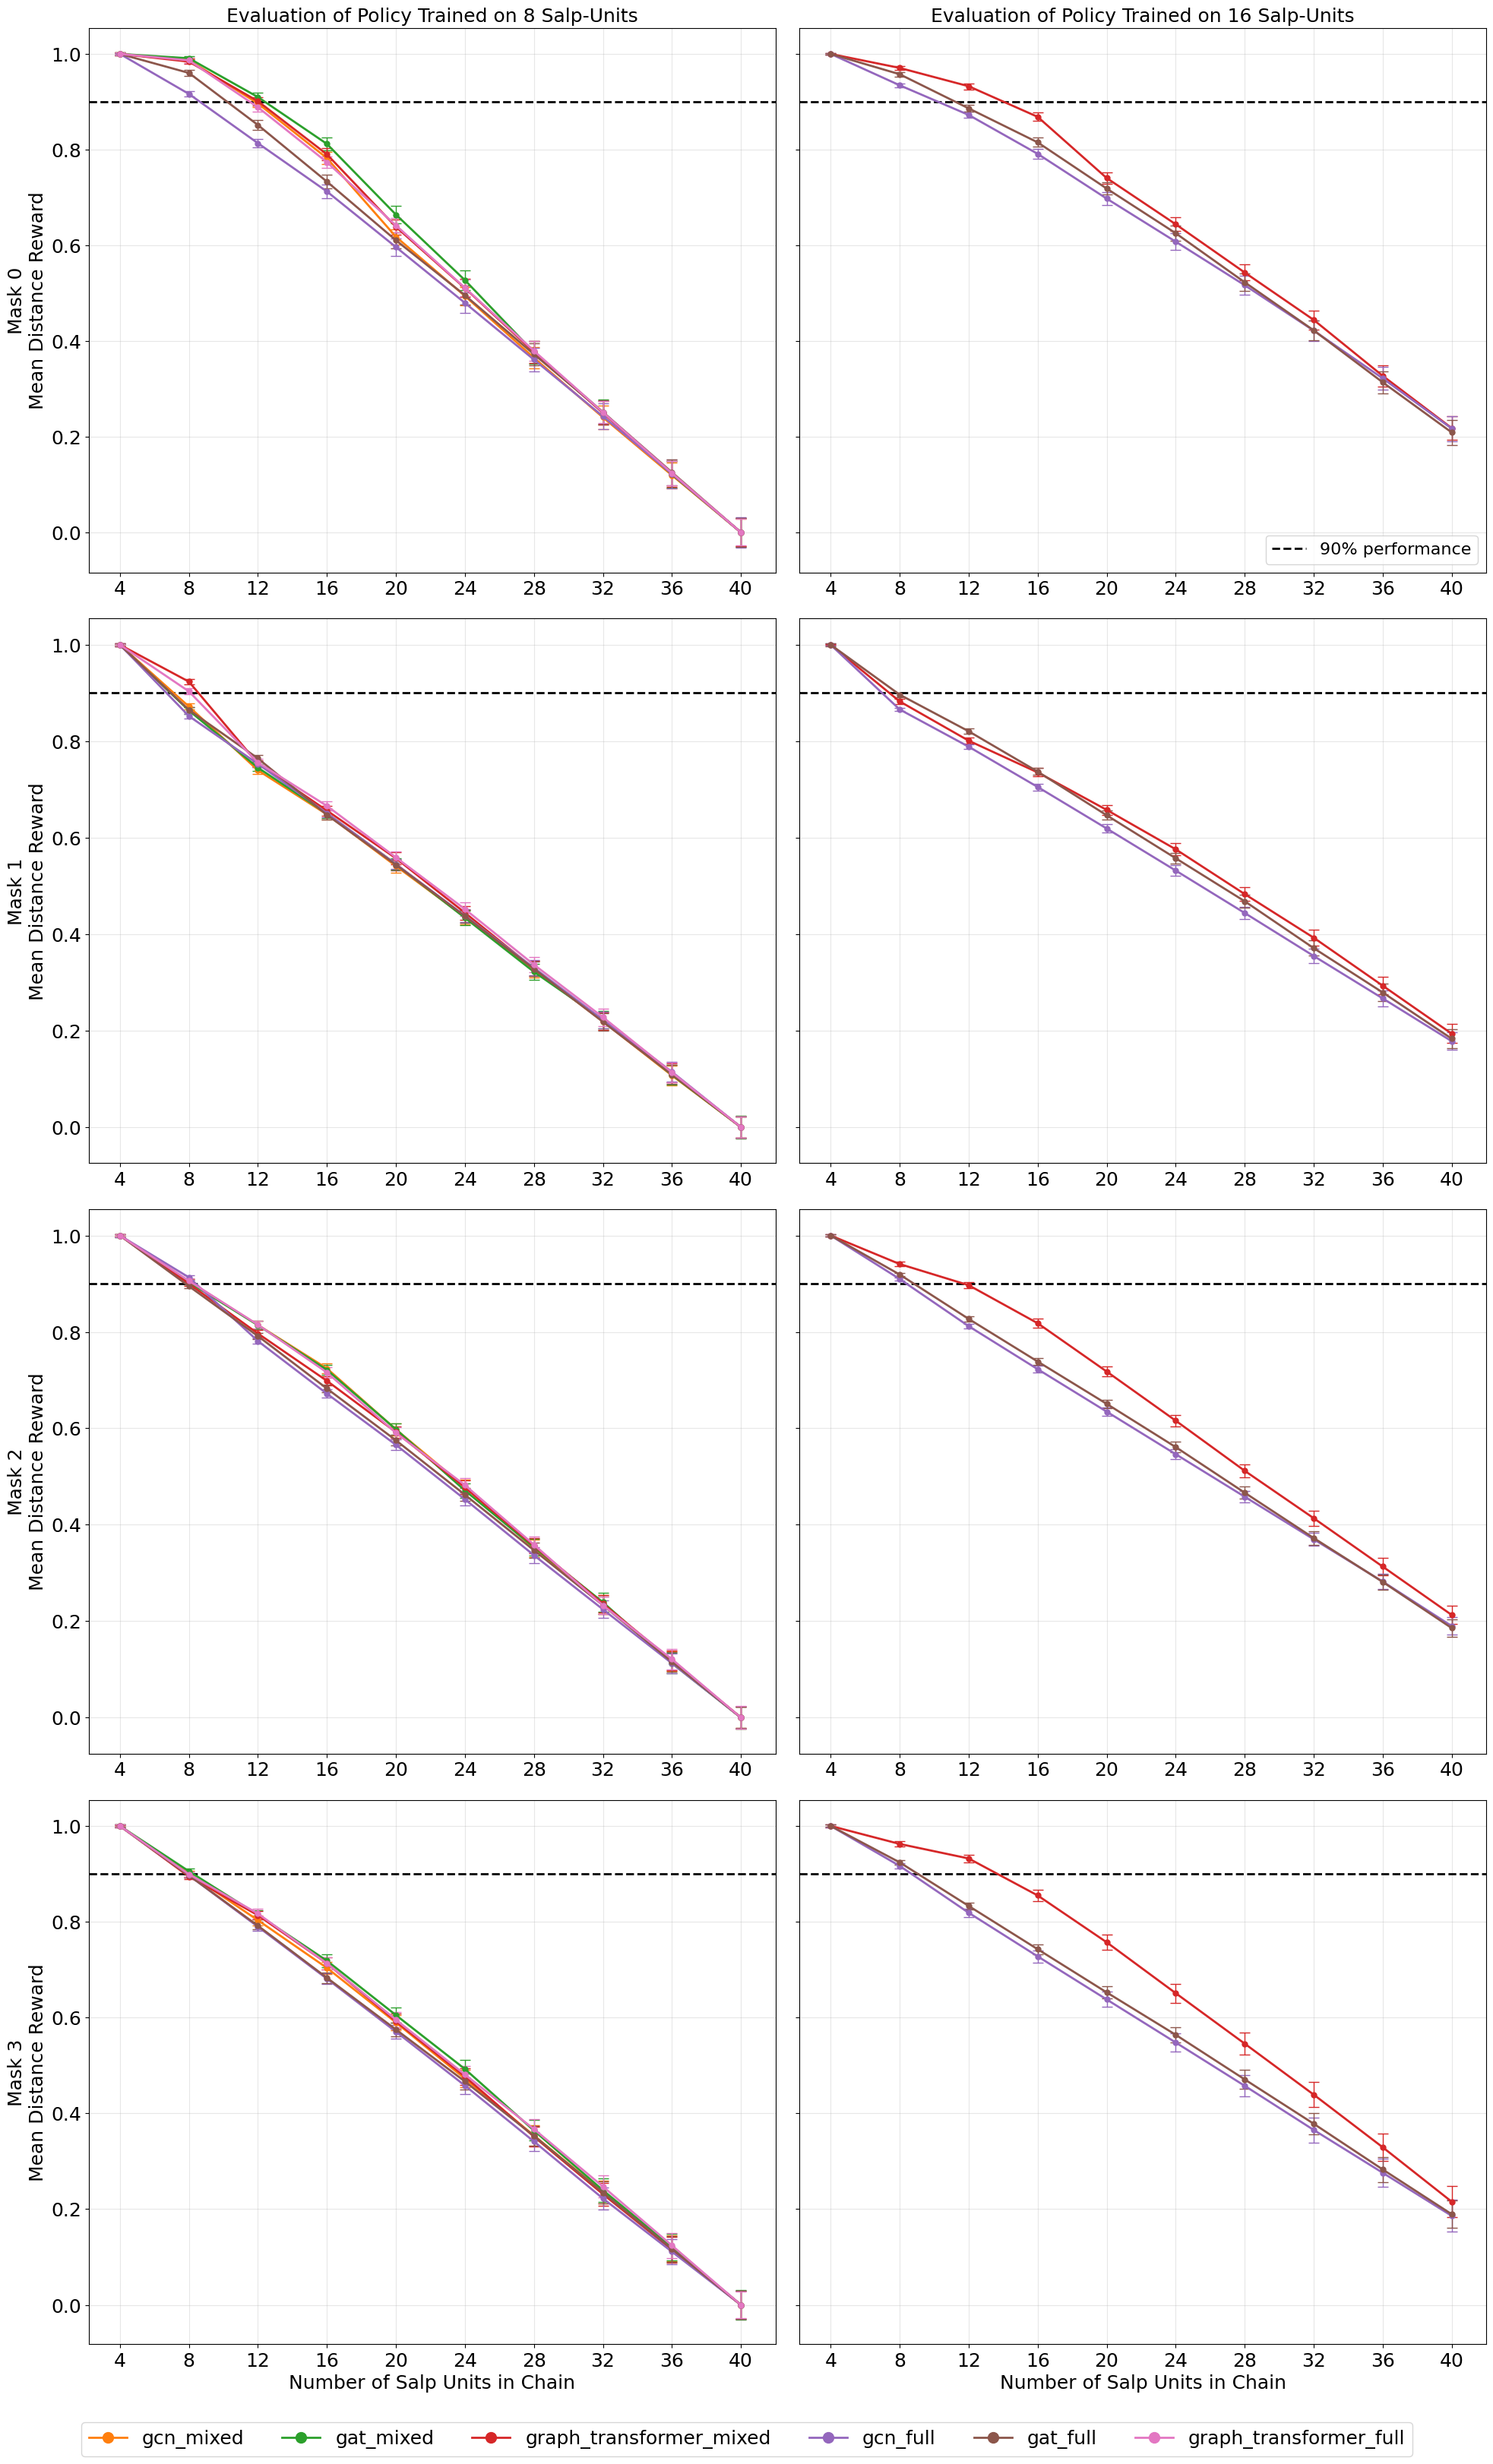

In [3]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import yaml
import pickle
from collections import defaultdict

# Set font properties for entire plot
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
})

plotting_dir = Path().resolve()
config_dir = plotting_dir / "ppo_config.yaml"


with open(config_dir, "r") as file:
    config = yaml.safe_load(file)

# Determine number of mask files
num_masks = 4  # You can make this dynamic by scanning files

# Create a figure with subplots: one row per mask_id, two columns for batches
fig, axes = plt.subplots(num_masks, 2, figsize=(20, 8 * num_masks), sharey='row')

# Group data by batch first, then by experiment, then by n_agents, then by mask_id
batch_data = {batch: defaultdict(lambda: defaultdict(lambda: defaultdict(list))) for batch in config["batches"]}
reward_name = "dist_rewards"

# First, collect all data points across trials
for batch in config["batches"]:
    for experiment in config["experiments"]:
        for trial in config["trials"]:
            for mask_id in range(0, num_masks):

                evaluation_file_name = f"disabled_evaluation_mask_{mask_id}"
                checkpoint_path = Path(f"{config['base_path']}/{batch}/{experiment}/{trial}/logs/{evaluation_file_name}.dat")

                if checkpoint_path.is_file():
                    with open(checkpoint_path, "rb") as handle:
                        data = pickle.load(handle)
                        
                        # Group rewards by n_agents, then by mask_id for this experiment
                        for n in data.keys():
                            batch_data[batch][experiment][n][mask_id].extend(data[n][reward_name])
                            
                    print(f"Added trial {trial} mask {mask_id} data to {batch}/{experiment}")

# Use a different color for each experiment
experiment_colors = {}
color_idx = 0

# Store line objects and labels for shared legend
all_lines = []
all_labels = []

# Subplot titles - customize as needed
titles = ["Evaluation of Policy Trained on 8 Salp-Units", "Evaluation of Policy Trained on 16 Salp-Units"]
all_labels = ["gcn_mixed", "gat_mixed", "graph_transformer_mixed", "gcn_full", "gat_full", "graph_transformer_full"]

# Now plot each mask_id and batch combination
for mask_id in range(num_masks):
    for batch_idx, batch in enumerate(config["batches"]):
        ax = axes[mask_id, batch_idx] if num_masks > 1 else axes[batch_idx]
        
        # Set subplot title
        if mask_id == 0:
            ax.set_title(titles[batch_idx])
        
        # Add mask_id label on the left
        if batch_idx == 0:
            ax.set_ylabel(f"Mask {mask_id}\nMean Distance Reward")
        
        # Process experiments for this batch and mask_id
        for experiment in config["experiments"]:
            # Skip if no data for this experiment
            if not batch_data[batch][experiment]:
                print(f"No data for {batch}/{experiment}")
                continue
                
            # Get consistent color for this experiment
            if experiment not in experiment_colors:
                experiment_colors[experiment] = plt.cm.tab10(color_idx+1 % 10)
                color_idx += 1
            color = experiment_colors[experiment]
            
            # Get sorted list of agent counts
            n_agents = sorted(batch_data[batch][experiment].keys())
            
            # Calculate mean and standard error across all trials for this specific mask_id
            means = [np.mean(batch_data[batch][experiment][n][mask_id]) if batch_data[batch][experiment][n][mask_id] else 0 
                     for n in n_agents]
            errors = [np.std(batch_data[batch][experiment][n][mask_id]) / 
                     np.sqrt(len(batch_data[batch][experiment][n][mask_id])) 
                     if len(batch_data[batch][experiment][n][mask_id]) > 0 else 0
                     for n in n_agents]
            
            # Normalize means and errors (accounting for negative values)
            if max(means) != min(means):
                min_mean = min(means)
                max_mean = max(means)
                range_mean = max_mean - min_mean
                means = [(m - min_mean) / range_mean for m in means]
                errors = [e / range_mean for e in errors]
            
            # Print how many samples we have for each agent count
            print(f"{batch}/{experiment}/mask_{mask_id}: {[len(batch_data[batch][experiment][n][mask_id]) for n in n_agents]} samples per agent count")
            
            n_set = 10
            # Plot with error bars
            line = ax.errorbar(
                n_agents[:n_set],
                means[:n_set],
                yerr=errors[:n_set],
                fmt="o-",
                linewidth=2,
                elinewidth=1,
                markersize=5,
                capsize=5,
                color=color,
                ecolor=color,
            )
            
            # Store line and label for shared legend, but only from first subplot
            if mask_id == 0 and batch_idx == 0:
                all_lines.append(line[0])
        
        ax.set_xticks(n_agents)
        if mask_id == num_masks - 1:  # Only add x-label to bottom row
            ax.set_xlabel("Number of Salp Units in Chain")
        ax.set_xlim(right=42)

        # Add horizontal line at 0.90
        ax.axhline(y=0.90, color='black', linestyle='--', linewidth=2, label='90% performance')
        
        ax.grid(True, alpha=0.3)

        # Add legend for the horizontal line to each subplot
        if mask_id == 0 and batch_idx == 1:  # Only on top right
            ax.legend(loc='lower right', fontsize=16)

# Create a single legend for the entire figure
fig.legend(all_lines, all_labels, 
           loc='lower center',
           bbox_to_anchor=(0.5, -0.02),
           ncol=len(all_labels),
           fontsize=18,
           markerscale=2)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.03)

plt.savefig("zero_shot_comparison_all_masks.png", dpi=300, bbox_inches="tight")
plt.show()